## Import data

In [68]:
import numpy as np
import tensorflow as tf
from numpy import genfromtxt
import matplotlib.pyplot as plt
np.random.seed(0) # please do not remove this line
tf.random.set_seed(0)

data = genfromtxt('titanic_modified_dataset.csv', delimiter=',', skip_header=1)

# shuffle
idx = np.arange(data.shape[0])
np.random.shuffle(idx)
data = data[idx]

N = data.shape[0]
X, y = data[:, 1:-1], data[:, -1]
y = y.reshape(-1,1)

print(X.shape, y.shape)


(891, 8) (891, 1)


In [69]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.2
#TEST_SIZE = 0.1
TRAIN_SAMPLES = int(TRAIN_SIZE * data.shape[0])
VAL_SAMPLES = TRAIN_SAMPLES + int(VAL_SIZE * data.shape[0])

X_b = X.copy()
X_train, y_train = X_b[:TRAIN_SAMPLES], y[:TRAIN_SAMPLES]
X_val, y_val = X_b[TRAIN_SAMPLES:VAL_SAMPLES], y[TRAIN_SAMPLES:VAL_SAMPLES]
X_test, y_test = X_b[VAL_SAMPLES:], y[VAL_SAMPLES:]

print(X_train.shape, X_test.shape)

(623, 8) (90, 8)


## Gradient Tape

Epoch: 20, Training log loss: 15.635
Epoch: 40, Training log loss: 2.294
Epoch: 60, Training log loss: 1.017
Epoch: 80, Training log loss: 0.961
Epoch: 100, Training log loss: 0.955
Epoch: 120, Training log loss: 0.951
Epoch: 140, Training log loss: 0.947
Epoch: 160, Training log loss: 0.943
Epoch: 180, Training log loss: 0.940


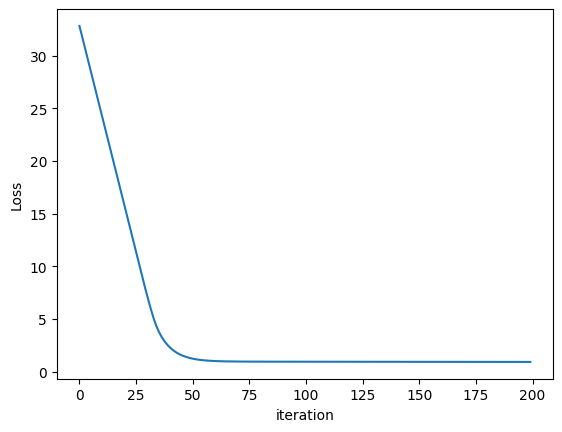

In [70]:
# mini-batch
num_labels = 2
num_features = 8
num_epochs = 200
lr = 0.001

losses = []
batch_size = X_train.shape[0]

### Create model
class Model(object):
    def __init__(self):
        # Initializing the weights and the biases
        self.W = tf.Variable(tf.random.truncated_normal([num_features, num_labels],dtype=tf.float64)) 
        self.b = tf.Variable(tf.zeros([num_labels],dtype=tf.float64)) 

    def __call__(self, x):        
        return tf.matmul(x, self.W) + self.b

def softmax_stable(Z):
    """
    Compute softmax values for each sets of scores in Z.
    each column of Z is a set of score.    
    If you use loss with softmax_cross_entropy_with_logits, softmax_stable inneeded.
    """
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

#Loss Function
def loss_fn(y_hat, y):            
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_hat))

model = Model()

for epoch in range(num_epochs):
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        y_batch = y_batch.reshape(y_batch.shape[0],1)
        with tf.GradientTape() as t:
            # feed forward
            y_batch_hat = model(X_batch)            

            # cross entropy loss 
            loss = loss_fn(y_batch_hat, y_batch)                      
            
        # debug
        losses.append(loss.numpy())

        # gradient
        dW, db = t.gradient(loss,[model.W, model.b])
        

        # update
        model.W.assign_sub(lr*dW)
        model.b.assign_sub(lr*db)
    if epoch % 20 == 0 and epoch != 0:
        print(f"Epoch: {epoch}, Training log loss: {loss:.3f}")

# plot losses
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.show()

## FIT

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
20/20 [==============================] - 1s 7ms/step - loss: 14.0973 - mse: 0.6308 - mae: 0.6308 - val_loss: 15.6251 - val_mse: 0.5222 - val_mae: 0.5222
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 13.4689 - mse: 0.6308 - mae: 0.6308 - val_loss: 14.9390 - val_mse: 0.5222 - val_mae: 0.5222
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 12.9214 - mse: 0.6308 - mae: 0.6308 - val_loss: 14.2982 - val_mse: 0.5222 - val_mae: 0.5222
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 12.3733 - mse: 0.63

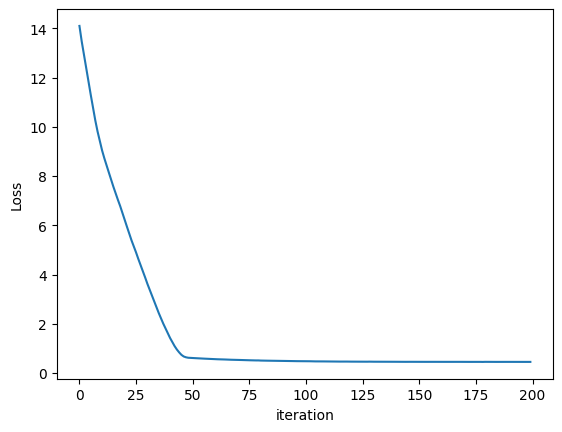

In [72]:
# 2-class softmax regression in Keras
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1, activation='softmax', input_dim=X_train.shape[1]))
model.compile(loss='binary_crossentropy', metrics=['mse', 'mae'])

model.summary()
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))

plt.plot(history.history['loss'])
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.show()